**Параметры инициализации**

In [1]:
gap_time = 1
#gap_time = 10  # gap time between each segment
win_size = [10, 30, 60]  # window size of each segment
step_max = 5 # maximum step of ConvLSTM


#raw_data_path = "output_file.csv"
raw_data_path = "month_finally_transposed_hourly_resampled.csv"  # path to load raw data
#model_path = '../MSCRED/'
train_data_path = ""
test_data_path = ""
reconstructed_data_path = ""

'''
train_start_id = 10
train_end_id = 800

test_start_id = 800
test_end_id = 2000

valid_start_id = 800
valid_end_id = 1000
'''
train_start_id = 10
train_end_id = 200

test_start_id = 200
test_end_id = 672

valid_start_id = 200
valid_end_id = 400


training_iters = 5
save_model_step = 1

learning_rate = 0.0002

threhold = 0.005
alpha = 1.5

**Генерация сигнатурных матриц**

In [2]:
import numpy as np
import pandas as pd
#import os


In [3]:
class SignatureMatrices:
    def __init__(self):

        #df = pd.read_csv(raw_data_path)
        #df_new = df.drop(labels=0, axis=1)
        self.raw_data = pd.read_csv(raw_data_path, index_col = 0)
        self.series_number = self.raw_data.shape[0]
        self.series_length = self.raw_data.shape[1]
        self.signature_matrices_number = int(self.series_length / gap_time)

        print("series_number is", self.series_number)
        print("series_length is", self.series_length)
        print("signature_matrices_number is", self.signature_matrices_number)

    def signature_matrices_generation(self, win):
        """
        Generation signature matrices according win_size and gap_time, the size of raw_data is n * T, n is the number of
        time series, T is the length of time series.
        To represent the inter-correlations between different pairs of time series in a multivariate time series segment
        from t − w to t, we construct an n × n signature matrix Mt based upon the pairwise inner-product of two time series
        within this segment.
        :param win: the length of the time series segment
        :return: the signature matrices
        """

        if win == 0:
            print("The size of win cannot be 0")

        raw_data = np.asarray(self.raw_data)
        signature_matrices = np.zeros((self.signature_matrices_number, self.series_number, self.series_number))

        for t in range(win, self.signature_matrices_number):
            raw_data_t = raw_data[:, t - win:t]
            signature_matrices[t] = np.dot(raw_data_t, raw_data_t.T) / win
            #print("signature_matrices[t]: " + str(signature_matrices[t]))

        return signature_matrices

    def generate_train_test(self, signature_matrices):
        """
        Generate train and test dataset, and store them to ../data/train/train.npy and ../data/test/test.npy
        :param signature_matrices:
        :return:
        """
        train_dataset = []
        test_dataset = []

        for data_id in range(self.signature_matrices_number):
            index = data_id - step_max + 1
            #print('Index:', index)
            if data_id < train_start_id:
                continue
            index_dataset = signature_matrices[:, index:index + step_max]
            if data_id < test_start_id:
                train_dataset.append(index_dataset)
            else:
                test_dataset.append(index_dataset)

        train_dataset = np.asarray(train_dataset)
        train_dataset = np.reshape(train_dataset, [-1, step_max, self.series_number, self.series_number,
                                                   signature_matrices.shape[0]])
        test_dataset = np.asarray(test_dataset)
        test_dataset = np.reshape(test_dataset, [-1, step_max,self.series_number, self.series_number,
                                                signature_matrices.shape[0]])

        print("train dataset shape is", train_dataset.shape)
        print("test dataset shape is", test_dataset.shape)

        train_path = ""
        #if not os.path.exists(train_path):
            #os.makedirs(train_path)
        train_path = "train.npy"

        test_path = ""
        #if not os.path.exists(test_path):
            #os.makedirs(test_path)
        test_path = "test.npy"

        np.save(train_path, train_dataset)
        np.save(test_path, test_dataset)


In [4]:
Matrices = SignatureMatrices()
signature_matrices = []

    # Generation signature matrices according the win size w
for w in win_size:
    signature_matrices.append(Matrices.signature_matrices_generation(w))
#print(signature_matrices)   

signature_matrices = np.asarray(signature_matrices)
print("the shape of signature_matrices is", signature_matrices.shape)

    # Generate train and test dataset
Matrices.generate_train_test(signature_matrices)


series_number is 4
series_length is 672
signature_matrices_number is 672
the shape of signature_matrices is (3, 672, 4, 4)
train dataset shape is (190, 5, 4, 4, 3)
test dataset shape is (472, 5, 4, 4, 3)


In [5]:
#import utils as util
import numpy as np
import os
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


def cnn_encoder_layer(data, filter_layer, strides):
    result = tf.nn.conv2d(
        input=data,
        filters=filter_layer,
        strides=strides,
        padding="SAME")
    return tf.nn.selu(result)


def tensor_variable(shape, name):
    variable = tf.Variable(tf.zeros(shape), name=name)
    variable = tf.compat.v1.get_variable(name, shape=shape, initializer=tf.compat.v1.keras.initializers.glorot_uniform())
    return variable


def cnn_encoder(data):
    filter1 = tensor_variable([3, 3, 3, 32], "filter1")
    strides1 = (1, 1, 1, 1)
    cnn1_out = cnn_encoder_layer(data, filter1, strides1)

    filter2 = tensor_variable([3, 3, 32, 64], "filter2")
    strides2 = (1, 2, 2, 1)
    cnn2_out = cnn_encoder_layer(cnn1_out, filter2, strides2)

    filter3 = tensor_variable([2, 2, 64, 128], "filter3")
    strides3 = (1, 2, 2, 1)
    cnn3_out = cnn_encoder_layer(cnn2_out, filter3, strides3)

    filter4 = tensor_variable([2, 2, 128, 256], "filter4")
    strides4 = (1, 2, 2, 1)
    cnn4_out = cnn_encoder_layer(cnn3_out, filter4, strides4)

    return cnn1_out, cnn2_out, cnn3_out, cnn4_out


def cnn_lstm_attention_layer(input_data, layer_number):
    #outputs = tf.compat.v1.placeholder(tf.float32, [5, 30, 30, 32])
    convlstm_layer = tf.compat.v1.keras.layers.ConvLSTM2D( 
        filters=input_data.shape[-1],
        padding='same',
        kernel_size=(2, 2),
        use_bias=True,
        return_sequences=True,
        name="conv_lstm_cell" + str(layer_number))
    #print('!', convlstm_layer )
    outputs = convlstm_layer(input_data)
    #outputs, state = tf.nn.dynamic_rnn(convlstm_layer, input_data, dtype=input_data.dtype)
    #print('!', outputs)

    #print('!', outputs)
    attention_w = []
    for k in range(step_max):
        attention_w.append(tf.reduce_sum(tf.multiply(outputs[:, k], outputs[:, -1])) / step_max)
    attention_w = tf.reshape(tf.nn.softmax(tf.stack(attention_w)), [1, step_max])
    #print(input_data.shape[2])
    outputs = tf.reshape(outputs, [step_max, -1])
    #print('!', outputs)
    # а вот это как раз та матрица, которая почему-то меньше нужного
    outputs = tf.matmul(attention_w, outputs)
    #ошибка в строке ниже
    #print(outputs)
    outputs = tf.reshape(outputs, [1, input_data.shape[2], input_data.shape[3], input_data.shape[4]])

    return outputs, attention_w


def cnn_decoder_layer(conv_lstm_out_c, filter, output_shape, strides):
    deconv = tf.nn.conv2d_transpose(
        value=conv_lstm_out_c,
        filters=filter,
        output_shape=output_shape,
        strides=strides,
        padding="SAME")
    deconv = tf.nn.selu(deconv)
    return deconv


def cnn_decoder(lstm1_out, lstm2_out, lstm3_out, lstm4_out):
    d_filter4 = tensor_variable([2, 2, 128, 256], "d_filter4")
    dec4 = cnn_decoder_layer(lstm4_out, d_filter4, [1, 8, 8, 128], (1, 2, 2, 1))
    dec4_concat = tf.concat([dec4, lstm3_out], axis=3)

    d_filter3 = tensor_variable([2, 2, 64, 256], "d_filter3")
    dec3 = cnn_decoder_layer(dec4_concat, d_filter3, [1, 15, 15, 64], (1, 2, 2, 1))
    dec3_concat = tf.concat([dec3, lstm2_out], axis=3)

    d_filter2 = tensor_variable([3, 3, 32, 128], "d_filter2")
    dec2 = cnn_decoder_layer(dec3_concat, d_filter2, [1, 30, 30, 32], (1, 2, 2, 1))
    dec2_concat = tf.concat([dec2, lstm1_out], axis=3)

    d_filter1 = tensor_variable([3, 3, 3, 64], "d_filter1")
    dec1 = cnn_decoder_layer(dec2_concat, d_filter1, [1, 30, 30, 3], (1, 1, 1, 1))

    return dec1


matrix_data_path = train_data_path + "train.npy"
matrix_gt_1 = np.load(matrix_data_path)

data_input = tf.compat.v1.placeholder(tf.float32, [5, 30, 30, 3])

conv1_out, conv2_out, conv3_out, conv4_out = cnn_encoder(data_input)

conv1_out = tf.reshape(conv1_out, [ 1, 5, 30, 30, 32])
    #print(conv1_out)
conv2_out = tf.reshape(conv2_out, [ 1, 5, 15, 15, 64])
conv3_out = tf.reshape(conv3_out, [ 1, 5, 8, 8, 128])
conv4_out = tf.reshape(conv4_out, [ 1, 5, 4, 4, 256])
conv1_lstm_attention_out, atten_weight_1 = cnn_lstm_attention_layer(conv1_out, 1)
 


    #conv1_lstm_attention_out, atten_weight_1 = cnn_lstm_attention_layer(conv1_out, 1)
conv2_lstm_attention_out, atten_weight_2 = cnn_lstm_attention_layer(conv2_out, 2)


       
conv3_lstm_attention_out, atten_weight_3 = cnn_lstm_attention_layer(conv3_out, 3)
conv4_lstm_attention_out, atten_weight_4 = cnn_lstm_attention_layer(conv4_out, 4)
    
deconv_out = cnn_decoder(conv1_lstm_attention_out, conv2_lstm_attention_out, conv3_lstm_attention_out,
                             conv4_lstm_attention_out)
print(deconv_out)
    
loss = tf.reduce_mean(tf.square(data_input[-1] - deconv_out))
    
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
init = tf.global_variables_initializer()
sess = tf.compat.v1.Session()
sess.run(init)
    
for idx in range(train_start_id, train_end_id):
    matrix_gt = matrix_gt_1[idx - train_start_id]
    feed_dict = {data_input: np.asarray(matrix_gt)}
    a, loss_value = sess.run([optimizer, loss], feed_dict)
    print("mse of last train data: " + str(loss_value))
   
matrix_data_path = test_data_path + "test.npy"
matrix_gt_1 = np.load(matrix_data_path)
result_all = []
for idx in range(test_start_id, test_end_id):
    matrix_gt = matrix_gt_1[idx - test_start_id]
    feed_dict = {data_input: np.asarray(matrix_gt)}
    result, loss_value = sess.run([deconv_out, loss], feed_dict)
    result_all.append(result)
    print("mse of last test data: " + str(loss_value))

reconstructed_path = reconstructed_data_path
#if not os.path.exists(reconstructed_path):
    #os.makedirs(reconstructed_path)
reconstructed_path = reconstructed_path + "test_reconstructed.npy"

result_all = np.asarray(result_all).reshape((-1, 30, 30, 3))
print(result_all.shape)
np.save(reconstructed_path, result_all)
    

In [43]:
def cnn_encoder_layer(data, filter_layer, strides):
    result = tf.nn.conv2d(
        input=data,
        filters=filter_layer,
        strides=strides,
        padding="SAME")
    return tf.nn.selu(result)


def tensor_variable(shape, name):
    with tf.compat.v1.variable_scope(tf.compat.v1.get_variable_scope(), reuse=tf.compat.v1.AUTO_REUSE):
        variable = tf.compat.v1.get_variable(name, shape=shape, initializer=tf.compat.v1.keras.initializers.glorot_uniform())
    return variable


def cnn_encoder(data):
    filter1 = tensor_variable([3, 3, 3, 32], "filter1")
    strides1 = (1, 1, 1, 1)
    cnn1_out = cnn_encoder_layer(data, filter1, strides1)
    # (5, 4, 4, 32)
    
    filter2 = tensor_variable([3, 3, 32, 64], "filter2")
    strides2 = (1, 2, 2, 1)
    cnn2_out = cnn_encoder_layer(cnn1_out, filter2, strides2)
    # (5, 2, 2, 64)
    
    return cnn1_out, cnn2_out#, cnn3_out, cnn4_out


def cnn_lstm_attention_layer(input_data, layer_number):
    #outputs = tf.compat.v1.placeholder(tf.float32, [5, 30, 30, 32])
    convlstm_layer = tf.compat.v1.keras.layers.ConvLSTM2D( 
        filters=input_data.shape[-1],
        padding='same',
        kernel_size=(2, 2),
        use_bias=True,
        return_sequences=True,
        name="conv_lstm_cell" + str(layer_number))
    #print('!', convlstm_layer )
    outputs = convlstm_layer(input_data)
    #outputs, state = tf.nn.dynamic_rnn(convlstm_layer, input_data, dtype=input_data.dtype)
    #print('!', outputs)

    #print('!', outputs)
    attention_w = []
    for k in range(step_max):
        attention_w.append(tf.reduce_sum(tf.multiply(outputs[:, k], outputs[:, -1])) / step_max)
    attention_w = tf.reshape(tf.nn.softmax(tf.stack(attention_w)), [1, step_max])
    #print(input_data.shape[2])
    outputs = tf.reshape(outputs, [step_max, -1])
    #print('!', outputs)
    # а вот это как раз та матрица, которая почему-то меньше нужного
    outputs = tf.matmul(attention_w, outputs)
    #ошибка в строке ниже
    #print(outputs)
    outputs = tf.reshape(outputs, [1, input_data.shape[2], input_data.shape[3], input_data.shape[4]])

    return outputs, attention_w


def cnn_decoder_layer(conv_lstm_out_c, filter, output_shape, strides):
    deconv = tf.nn.conv2d_transpose(
        value=conv_lstm_out_c,
        filters=filter,
        output_shape=output_shape,
        strides=strides,
        padding="SAME")
    deconv = tf.nn.selu(deconv)
    return deconv


def cnn_decoder(lstm1_out, lstm2_out):
    
    '''
    d_filter2 = tensor_variable([3, 3, 32, 128], "d_filter2")
    dec2 = cnn_decoder_layer(lstm2_out, d_filter2, [1, 4, 4, 32], (1, 2, 2, 1))
    dec2_concat = tf.concat([dec2, lstm1_out], axis=3)
    '''
    d_filter1 = tensor_variable([3, 3, 3, 64], "d_filter1")
    dec1 = cnn_decoder_layer(lstm2_out, d_filter1, [1, 4, 4, 3], (1, 2, 2, 1))
    
    '''
    d_filter4 = tensor_variable([2, 2, 128, 256], "d_filter4")
    dec4 = cnn_decoder_layer(lstm4_out, d_filter4, [1, 8, 8, 128], (1, 2, 2, 1))
    dec4_concat = tf.concat([dec4, lstm3_out], axis=3)

    d_filter3 = tensor_variable([2, 2, 64, 256], "d_filter3")
    dec3 = cnn_decoder_layer(dec4_concat, d_filter3, [1, 15, 15, 64], (1, 2, 2, 1))
    dec3_concat = tf.concat([dec3, lstm2_out], axis=3)
    
    d_filter2 = tensor_variable([3, 3, 32, 128], "d_filter2")
    dec2 = cnn_decoder_layer(dec3_concat, d_filter2, [1, 30, 30, 32], (1, 2, 2, 1))
    dec2_concat = tf.concat([dec2, lstm1_out], axis=3)

    d_filter1 = tensor_variable([3, 3, 3, 64], "d_filter1")
    dec1 = cnn_decoder_layer(dec2_concat, d_filter1, [1, 30, 30, 3], (1, 1, 1, 1))
    '''
    return dec1


In [46]:
matrix_data_path = train_data_path + "train.npy"
matrix_gt_1 = np.load(matrix_data_path)

data_input = tf.compat.v1.placeholder(tf.float32, [5, 4, 4, 3])

#conv1_out, conv2_out, conv3_out, conv4_out = cnn_encoder(data_input)
conv1_out, conv2_out = cnn_encoder(data_input)

#print(conv1_out.shape)
#print(conv2_out.shape)

conv1_out = tf.reshape(conv1_out, [ 1, 5, 4, 4, 32])
    
conv2_out = tf.reshape(conv2_out, [ 1, 5, 2, 2, 64])
#conv3_out = tf.reshape(conv3_out, [ 1, 5, 8, 8, 128])
#conv4_out = tf.reshape(conv4_out, [ 1, 5, 4, 4, 256])
conv1_lstm_attention_out, atten_weight_1 = cnn_lstm_attention_layer(conv1_out, 1)
 
#print('conv1_lstm_attention_out', conv1_lstm_attention_out)

#conv1_lstm_attention_out, atten_weight_1 = cnn_lstm_attention_layer(conv1_out, 1)
conv2_lstm_attention_out, atten_weight_2 = cnn_lstm_attention_layer(conv2_out, 2)

#print('conv2_lstm_attention_out', conv2_lstm_attention_out)

       
#conv3_lstm_attention_out, atten_weight_3 = cnn_lstm_attention_layer(conv3_out, 3)
#conv4_lstm_attention_out, atten_weight_4 = cnn_lstm_attention_layer(conv4_out, 4)
    
#deconv_out = cnn_decoder(conv1_lstm_attention_out, conv2_lstm_attention_out, conv3_lstm_attention_out,
                             #conv4_lstm_attention_out)

deconv_out = cnn_decoder(conv1_lstm_attention_out, conv2_lstm_attention_out)

#print(deconv_out.shape)

loss = tf.reduce_mean(tf.square(data_input[-1] - deconv_out))

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss)
    
init = tf.global_variables_initializer()
sess = tf.compat.v1.Session()
sess.run(init)


for idx in range(train_start_id, train_end_id):
    matrix_gt = matrix_gt_1[idx - train_start_id]
    feed_dict = {data_input: np.asarray(matrix_gt)}
    a, loss_value = sess.run([optimizer, loss], feed_dict)
    print("mse of last train data: " + str(loss_value))
   
matrix_data_path = test_data_path + "test.npy"
matrix_gt_1 = np.load(matrix_data_path)
result_all = []
for idx in range(test_start_id, test_end_id):
    matrix_gt = matrix_gt_1[idx - test_start_id]
    feed_dict = {data_input: np.asarray(matrix_gt)}
    result, loss_value = sess.run([deconv_out, loss], feed_dict)
    result_all.append(result)
    print("mse of last test data: " + str(loss_value))

reconstructed_path = reconstructed_data_path
#if not os.path.exists(reconstructed_path):
    #os.makedirs(reconstructed_path)
reconstructed_path = reconstructed_path + "test_reconstructed.npy"

result_all = np.asarray(result_all).reshape((-1, 30, 30, 3))
print(result_all.shape)
np.save(reconstructed_path, result_all)


mse of last train data: 0.00011734221
mse of last train data: 8.822079e-05
mse of last train data: 0.0002242221
mse of last train data: 0.00018262731
mse of last train data: 0.00015507916
mse of last train data: 0.00010455613
mse of last train data: 7.146263e-05
mse of last train data: 5.2520376e-05
mse of last train data: 4.2113898e-05
mse of last train data: 3.865283e-05
mse of last train data: 4.47692e-05
mse of last train data: 4.6136032e-05
mse of last train data: 4.1108433e-05
mse of last train data: 3.0482348e-05
mse of last train data: 2.5354331e-05
mse of last train data: 2.3305065e-05
mse of last train data: 2.7052143e-05
mse of last train data: 2.6708898e-05
mse of last train data: 2.4914823e-05
mse of last train data: 2.005181e-05
mse of last train data: 2.3512212e-05
mse of last train data: 4.562733e-05
mse of last train data: 3.0212012e-05
mse of last train data: 3.4564393e-05
mse of last train data: 6.194812e-05
mse of last train data: 3.41761e-05
mse of last train data:

ValueError: cannot reshape array of size 22656 into shape (30,30,3)

**Оценка данных на предмет аномалий**

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import os
#import utils as util
import re

The shape of test data is (13290, 30, 30, 3)
The shape of reconstructed data is (1200, 30, 30, 3)
Max valid anom is 2.00
Threshold is 3.00


C:\Users\Admin\AppData\Local\Temp\ipykernel_5380\2900159533.py:64: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes.set_xticklabels(labels, rotation = 25, fontsize = 20)


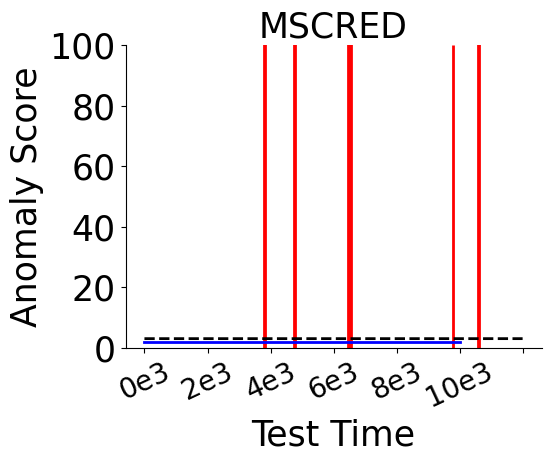

In [11]:
# score initialization
valid_anomaly_score = np.zeros((valid_end_id - valid_start_id, 1))
test_anomaly_score = np.zeros((test_end_id - valid_end_id, 1))

# load the data from file
test_data_path = test_data_path
reconstructed_data_path = reconstructed_data_path
test_data_path = os.path.join(test_data_path, "test.npy")
reconstructed_data_path = os.path.join(reconstructed_data_path, "test_reconstructed.npy")
test_data = np.load("test.npy")
test_data = test_data[:, -1, ...]  # only compare the last matrix with the reconstructed data
reconstructed_data = np.load("test_reconstructed.npy")
print("The shape of test data is {}".format(test_data.shape))
print("The shape of reconstructed data is {}".format(reconstructed_data.shape))

valid_len = valid_end_id - valid_start_id

# compute the threshold, threshold = alpha * max{s(t)} , s(t) is the anomaly scores over validation period.
for i in range(valid_end_id - valid_start_id):
	error = np.square(np.subtract(test_data[i, ..., 0], reconstructed_data[i, ..., 0]))
	num_anom = len(np.where(error > threhold))
	valid_anomaly_score[i] = num_anom

max_valid_anom = np.max(valid_anomaly_score)
threshold = max_valid_anom * alpha

print("Max valid anom is %.2f" % max_valid_anom)
print("Threshold is %.2f" % threshold)

# compute the anomaly score in the test data.
for i in range(test_end_id - valid_end_id):
	error = np.square(np.subtract(test_data[i, ..., 0], reconstructed_data[i, ..., 0]))
	num_anom = len(np.where(error > threshold))
	test_anomaly_score[i - valid_len] = num_anom

# plot anomaly score curve and identification result
anomaly_pos = np.zeros(5)
root_cause_gt = np.zeros((5, 3))
anomaly_span = [10, 30, 90]

# Read the test_anomaly.csv, each line behalf of an anomaly, the first is the position, the next three number is the
# root cause.
root_cause_f = open("test_anomaly.csv", "r")

root_cause_gt = np.loadtxt(root_cause_f, delimiter=",", dtype=np.int32)
anomaly_pos = root_cause_gt[:, 0]
anomaly_pos = [(anomaly_pos[i]/gap_time-test_start_id-anomaly_span[i % 3]/gap_time) for i in range(5)]
for i in range(5):
	root_cause_gt[i][0] = anomaly_pos[i]


fig, axes = plt.subplots()
test_num = test_end_id - test_start_id
plt.xticks(fontsize = 25)
plt.ylim((0, 100))
plt.yticks(np.arange(0, 101, 20), fontsize = 25)
plt.plot(test_anomaly_score, 'b', linewidth = 2)
threshold = np.full((test_num), max_valid_anom * alpha)
axes.plot(threshold, color = 'black', linestyle = '--',linewidth = 2)
for k in range(len(anomaly_pos)):
	axes.axvspan(anomaly_pos[k], anomaly_pos[k] + anomaly_span[k%3]/gap_time, color='red', linewidth=2)

labels = [' ', '0e3', '2e3', '4e3', '6e3', '8e3', '10e3']
axes.set_xticklabels(labels, rotation = 25, fontsize = 20)
plt.xlabel('Test Time', fontsize = 25)
plt.ylabel('Anomaly Score', fontsize = 25)
axes.spines['right'].set_visible(False)
axes.spines['top'].set_visible(False)
axes.yaxis.set_ticks_position('left')
axes.xaxis.set_ticks_position('bottom')
fig.subplots_adjust(bottom=0.25)
fig.subplots_adjust(left=0.25)
plt.title("MSCRED", size = 25)
plt.show()
